# Notebook for benchmarking U-track against Deeptrack


## 1. Initialization


### 1a. Imports


In [2]:
import deeptrack, imageGeneration, unet, benchmark
from matplotlib import pyplot as plt
import numpy as np

#import networks
unet_model = unet.create_unet("Network - uTrack.hdf5")
deeptrack_network = deeptrack.load("DeepTrack - Example 1a - Pretrained network.h5")

In [3]:
#bugfix for fredrik REMOVE LATER
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### 1b. Define image parameters function

In [4]:
def get_image_parameters_multiple_particles(SNR, allow_overlap = True):
    from numpy.random import uniform, randint, exponential
    from numpy import ones, clip
    from math import pi
    
    image_size = 256
    
    particle_number = randint(10, 20)
    particle_radius_list = uniform(2, 8, particle_number)
    (particle_center_x_list, particle_center_y_list) = imageGeneration.generate_particle_positions(particle_radius_list, image_size, allow_overlap = allow_overlap)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([randint(1,3), ])
        particle_intensities_list.append([uniform(0.1, 0.3, 1), ])

    image_parameters = imageGeneration.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list, 
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(0.1, 0.3),
        signal_to_noise_ratio=lambda: SNR,
        gradient_intensity=lambda: uniform(0, 0.4),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters

### 2a. Calculate optimal parameters for SNR = 1 and SNR = 10

#### Optimal cutoff

In [6]:
import time
from numpy import zeros

#Define parameters
SNRs = [1,10]
optimal_cutoffs = zeros(len(SNRs))
batch_size_for_optimization = 400
image_size_x = 256
image_size_y = 256
scanning_box_size_x = 10
scanning_box_size_y = 10
number_of_extra_iterations = 2

for i,SNR in enumerate(SNRs):
    print("SNR = {}".format(SNR))
    
    
    # Find optimal cutoff by first generating a batch for the current SNR, then finding optimal cutoff on this batch
    batch_for_finding_parameters = imageGeneration.get_batch(lambda: get_image_parameters_multiple_particles(SNR),
                                                         batch_size = batch_size_for_optimization, suppress_warnings = True, verbose = False)

    (batch_images, batch_labels, batch_predictions, batch_particle_attributes) = batch_for_finding_parameters
    batch_predictions_unet = unet.predict(unet_model, batch_images)

    t1 = time.time()
    
    optimal_cutoff = benchmark.get_optimal_parameters_unet(batch_predictions_unet,
                                                           batch_particle_attributes,
                                                           image_size_x, image_size_y,
                                                           scanning_box_size_x, scanning_box_size_y,
                                                           batch_size_for_optimization,
                                                           number_of_extra_iterations)

    t2 = time.time()
    print("Time for optimization: {} s".format(t2-t1))
    print("Optimal cutoff: {}".format(optimal_cutoff))
    optimal_cutoffs[i] = optimal_cutoff

SNR = 1
Time for optimization: 1.5166935920715332 s
Optimal cutoff: [0.9671875]
SNR = 10
Time for optimization: 1.5530891418457031 s
Optimal cutoff: [0.8]


#### Optimal parameters for deeptrack

In [9]:
import time
from numpy import zeros

#Define parameters.
#Since the optmization of deeptrack's parameters take alot more time than the optimization of cutoff for Utrack,
#the batch size aught to be alot smaller. As visualized in the evaluation of the optimal parameters, this comparably
#small batch suffices to arrive near the optimum.
SNRs = [1,10]
DT_first_parameter = zeros(len(SNRs))
DT_second_parameter = zeros(len(SNRs))
batch_size_for_optimization = 20
image_size_x = 256
image_size_y = 256
scanning_box_size_x = 10
scanning_box_size_y = 10
number_of_extra_iterations = 2

for i,SNR in enumerate(SNRs):
    print("SNR = {}".format(SNR))
    
    # Find optimal parameters by first generating a batch for the current SNR, then finding optimal cutoff on this batch
    batch_for_finding_parameters = imageGeneration.get_batch(lambda: get_image_parameters_multiple_particles(SNR),
                                                         batch_size = batch_size_for_optimization, suppress_warnings = True, verbose = False)
    
    
    (number_frames_to_be_tracked,
     frames, predicted_positions_wrt_frame,
     predicted_positions_wrt_box, boxes_all) = benchmark.predict_batch_deeptrack(deeptrack_network,
                                                                                 batch_images,
                                                                                 box_half_size=20,
                                                                                 box_scanning_step=4)


    t1 = time.time()
    optimal_parameters_deeptrack = benchmark.get_optimal_parameters_DT(predicted_positions_wrt_frame,
                                                             batch_particle_attributes,
                                                             image_size_x, image_size_y,
                                                             scanning_box_size_x, scanning_box_size_y,
                                                             sample_size=batch_size_for_optimization,
                                                             number_of_iterations=number_of_extra_iterations,
                                                             x0=[8, 8],
                                                             verbose=False,
                                                             FPR_weight=1)
    
    DT_first_parameter[i] = optimal_parameters_deeptrack[0]
    DT_second_parameter[i] = optimal_parameters_deeptrack[1]
    
    t2 = time.time()
    print("Time for optimization: {} s".format(t2-t1))
    print("Optimal parameters: {}".format(optimal_parameters_deeptrack))
    print()



SNR = 1
Time for optimization: 34.1303493976593 s
Optimal parameters: [ 1.925 20.3  ]

SNR = 10
Time for optimization: 34.572425365448 s
Optimal parameters: [ 1.925 20.3  ]



### 2b. Create linearly spaced vector of values spread between optimal values

These values will be used as approximation of optimal parameters since the parameters are stipulated to relate about linearly to the value of SNR.

In [10]:
cutoffs_extended = np.linspace(optimal_cutoffs[0],optimal_cutoffs[1],10)
print(cutoffs_extended)
DT_first_parameter_extended = np.linspace(DT_first_parameter[0],DT_first_parameter[1],10)
print(DT_first_parameter_extended)
DT_second_parameter_extended = np.linspace(DT_second_parameter[0],DT_second_parameter[1],10)
print(DT_second_parameter_extended)

[0.9671875  0.94861111 0.93003472 0.91145833 0.89288194 0.87430556
 0.85572917 0.83715278 0.81857639 0.8       ]
[1.925 1.925 1.925 1.925 1.925 1.925 1.925 1.925 1.925 1.925]
[20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3 20.3]


### 2c. Evaluate optimality 

The optimality for deeptrack's parameters is done by fixing one of them and varying the other in a interval around the calculated optimum. This is note a proof of optimality but rather a visualization hopefully confirming that the calculated optimum is reasonable.

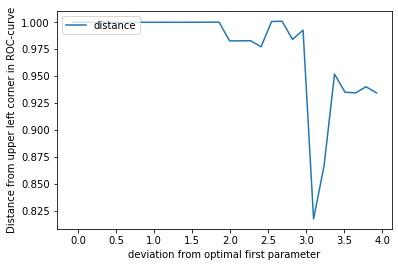

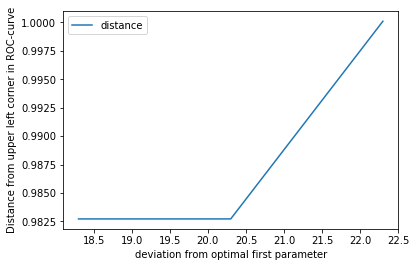

In [11]:
import matplotlib.pyplot as plt

# Define ranges and variables. Adapt these to the results from the optimizations
params = [DT_first_parameter[1],DT_second_parameter[1]]
diffs = np.linspace(params[0]-2,params[0]+2,30)
distance = np.zeros(len(diffs))
verbose = False
SNR = 10
batch_size_for_evaluation = 100
scanning_box_size_x = 10
scanning_box_size_y = 10
scanning_box_step_x = scanning_box_size_x / 4
scanning_box_step_y = scanning_box_size_y / 4

# Generate batch
(batch_images, batch_labels, batch_predictions, batch_particle_attributes) = imageGeneration.get_batch(lambda: get_image_parameters_multiple_particles(SNR),
                                                     batch_size = batch_size_for_evaluation, suppress_warnings = True, verbose = False)
    

for i,diff in enumerate(diffs,0):
    predicted_positions_DT = benchmark.get_predicted_positions_DT(diff,
                                                                  params[1],
                                                                  number_frames_to_be_tracked,
                                                                  predicted_positions_wrt_frame,
                                                                  verbose = False)
    

    P, N, TP, FP, TN, FN = benchmark.get_op_chars(predicted_positions_DT,
                                        batch_particle_attributes,
                                        image_size_x, image_size_y,
                                        scanning_box_size_x, scanning_box_size_y,
                                        scanning_box_step_x, scanning_box_step_y)

    
    dist = benchmark.distance_from_upper_left_corner_ROC((P, N, TP, FP, TN, FN),1)
    distance[i] = dist
    
    if(verbose):print(dist)


plt.plot(diffs,distance,label = "distance")
plt.legend(loc="upper left")
plt.xlabel("Deeptrack's first parameter")
plt.ylabel("Distance from upper left corner in ROC-curve")
plt.show()




##now vary second parameter
diffs = np.linspace(params[1]-2,params[1]+2,3)
distance = np.zeros(len(diffs))

verbose = False

for i,diff in enumerate(diffs,0):
    predicted_positions_DT = benchmark.get_predicted_positions_DT(params[0],
                                                                  diff,
                                                                  number_frames_to_be_tracked,
                                                                  predicted_positions_wrt_frame,
                                                                  verbose = False)


    P, N, TP, FP, TN, FN = benchmark.get_op_chars(predicted_positions_DT,
                                        batch_particle_attributes,
                                        image_size_x, image_size_y,
                                        scanning_box_size_x, scanning_box_size_y,
                                        scanning_box_step_x, scanning_box_step_y)

    
    dist = benchmark.distance_from_upper_left_corner_ROC((P, N, TP, FP, TN, FN),1)
    distance[i] = dist
    
    if(verbose):print(dist)

plt.plot(diffs,distance,label = "distance")
plt.legend(loc="upper left")
plt.xlabel("Deeptrack's second parameter")
plt.ylabel("Distance from upper left corner in ROC-curve")
plt.show()

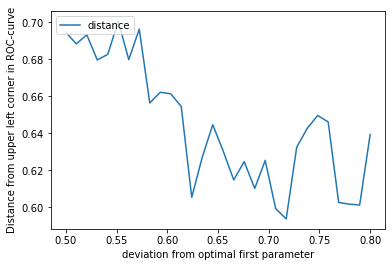

In [13]:
import matplotlib.pyplot as plt

# Define ranges and variables. Adapt these to the results from the optimizations
optimal_cutoff = optimal_cutoffs[0]
cutoffs = np.linspace(0.5,0.8,30)
distance = np.zeros(len(cutoffs))

SNR = 1
batch_size_for_evaluation = 100
# Find optimal cutoff by first generating a batch for the current SNR, then finding optimal cutoff on this batch
(batch_images,
 batch_labels,
 batch_predictions,
 batch_particle_attributes) = imageGeneration.get_batch(lambda: get_image_parameters_multiple_particles(SNR),
                                                     batch_size = batch_size_for_evaluation, suppress_warnings = True, verbose = False)

image_width = 256 
image_height = 256
scanning_box_size_x = 10
scanning_box_size_y = 10
scanning_box_step_x = scanning_box_size_x / 4
scanning_box_step_y = scanning_box_size_y / 4

verbose = False
for i,cutoff in enumerate(cutoffs,0):
    batch_predictions_unet = unet.predict(unet_model, batch_images)
    
    batch_predictions_unet = benchmark.get_predicted_positions_unet(batch_size_for_optimization,
                                                                    batch_predictions_unet,
                                                                    image_width, image_height,
                                                                    cutoff_value=cutoff)
    
    P, N, TP, FP, TN, FN = benchmark.get_op_chars(batch_predictions_unet,
                                        batch_particle_attributes,
                                        image_width, image_height,
                                        scanning_box_size_x, scanning_box_size_y,
                                        scanning_box_step_x, scanning_box_step_y)

    
    dist = benchmark.distance_from_upper_left_corner_ROC((P, N, TP, FP, TN, FN),1)
    distance[i] = dist
    
    if(verbose):print(dist)


plt.plot(cutoffs,distance,label = "distance")
plt.legend(loc="upper left")
plt.xlabel("deviation from optimal first parameter")
plt.ylabel("Distance from upper left corner in ROC-curve")
plt.show()

## 3. uTrack vs deeptrack

SNR: 1
Optimal cutoff: 0.9671875000000008
Optimal parameters: [1.9249999999999856, 20.29999999999994]

SNR: 2
Optimal cutoff: 0.9486111111111117
Optimal parameters: [1.9249999999999856, 20.29999999999994]

SNR: 3
Optimal cutoff: 0.9300347222222228
Optimal parameters: [1.9249999999999856, 20.29999999999994]

SNR: 4
Optimal cutoff: 0.9114583333333338
Optimal parameters: [1.9249999999999856, 20.29999999999994]

SNR: 5
Optimal cutoff: 0.8928819444444449
Optimal parameters: [1.9249999999999856, 20.29999999999994]

SNR: 6
Optimal cutoff: 0.8743055555555559
Optimal parameters: [1.9249999999999856, 20.29999999999994]

SNR: 7
Optimal cutoff: 0.855729166666667
Optimal parameters: [1.9249999999999856, 20.29999999999994]

SNR: 8
Optimal cutoff: 0.837152777777778
Optimal parameters: [1.9249999999999856, 20.29999999999994]

SNR: 9
Optimal cutoff: 0.8185763888888891
Optimal parameters: [1.9249999999999856, 20.29999999999994]

SNR: 10
Optimal cutoff: 0.8
Optimal parameters: [1.9249999999999856, 20.299

C:\Users\fredr\Miniconda3\envs\kand\lib\site-packages\ipykernel_launcher.py:139: UserWarning: Legend does not support 'd' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
C:\Users\fredr\Miniconda3\envs\kand\lib\site-packages\ipykernel_launcher.py:139: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
C:\Users\fredr\Miniconda3\envs\kand\lib\site-packages\ipykernel_launcher.py:139: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


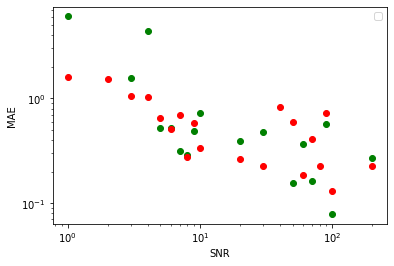

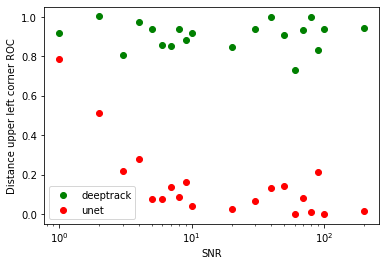

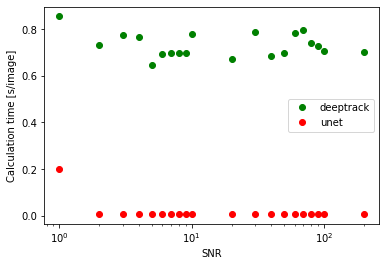

In [35]:
import time

#Define intervalls.
#For the parameters, the values for SNRs between 1 and 10 is a linear spread between the optimal paramters for 
#SNR = 1 and SNR = 10. For SNRs larger than 10, the optimal parameters for SNR = 10 is used.
SNRs = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200]
cutoffs = np.zeros(len(SNRs))
cutoffs[0:10] = cutoffs_extended
cutoffs[10:] = cutoffs[9]
DT_first_parameter = np.zeros(len(SNRs))
DT_first_parameter[0:10] = DT_first_parameter_extended
DT_first_parameter[10:] = DT_first_parameter[9]
DT_second_parameter = np.zeros(len(SNRs))
DT_second_parameter[0:10] = DT_second_parameter_extended
DT_second_parameter[10:] = DT_second_parameter[9]


#Create empty result lists
MAEs_deeptrack_multi = []
Distance_upper_left_deeptrack = []
Calculation_time_deeptrack = []
MAEs_unet = []
Distance_upper_left_unet = []
Calculation_time_unet = []

#Define testing batch size and scanning box parameters.
batch_size_for_testing = 100
image_size_x = 256 
image_size_y = 256
scanning_box_size_x = 10
scanning_box_size_y = 10
scanning_box_step_x = scanning_box_size_x / 4
scanning_box_step_y = scanning_box_size_y / 4


for i,SNR in enumerate(SNRs,0):
    print("SNR: {}".format(SNR))
    
    optimal_cutoff = cutoffs[i]
    
    print("Optimal cutoff: {}".format(optimal_cutoff))
    
    optimal_parameters_deeptrack = [DT_first_parameter[i],DT_second_parameter[i]]
    
    print("Optimal parameters: {}".format(optimal_parameters_deeptrack))
    print()
    
    #Generate batch for testing
    batch_for_testing = imageGeneration.get_batch(lambda: get_image_parameters_multiple_particles(SNR),
                             batch_size = batch_size_for_testing, suppress_warnings = True, verbose = False)
    
    
    (batch_images, batch_labels, batch_predictions, batch_particle_attributes) = batch_for_testing
    
    #Predict using Utrack and calculate MAE and distance to upper left corner in ROC curve.
    t1 = time.time()
    batch_predictions_unet = unet.predict(unet_model, batch_images)
    t2 = time.time()
    Calculation_time_unet.append((t2-t1)/batch_size_for_testing)
    batch_predictions_unet_formatted = benchmark.get_predicted_positions_unet(batch_size_for_testing,
                                                              batch_predictions_unet,
                                                              image_size_x, image_size_y,
                                                              cutoff_value=optimal_cutoff)
    
    (nr_real_particles,
     nr_predictions,
     nr_true_positives,
     nr_false_positives,
     true_positives,
     false_positives,
     true_positive_links,
     MAE,
     MSE) = benchmark.hits_and_misses(batch_size_for_testing,
                                      batch_predictions_unet_formatted,
                                      batch_particle_attributes,
                                      long_return=True)
        
    
    operating_characteristics_unet = benchmark.get_op_chars(batch_predictions_unet_formatted,
                                            batch_particle_attributes,
                                            image_size_x, image_size_y,
                                            scanning_box_size_x, scanning_box_size_y,
                                            scanning_box_step_x, scanning_box_step_y)

    
    dist_unet = benchmark.distance_from_upper_left_corner_ROC(operating_characteristics_unet,1)
    
    
    MAEs_unet.append(MAE); Distance_upper_left_unet.append(dist_unet)
    
    
    
    
    #Predict using deeptrack and calculate MAE and distance to upper left corner in ROC curve.
    t3 = time.time()
    (number_frames_to_be_tracked,
     frames, predicted_positions_wrt_frame,
     predicted_positions_wrt_box,
     boxes_all) = benchmark.predict_batch_deeptrack(deeptrack_network, batch_images, box_half_size=30,box_scanning_step=10)
    t4 = time.time()
    Calculation_time_deeptrack.append((t4-t3)/batch_size_for_testing)
    batch_predictions_deeptrack_formatted = benchmark.get_predicted_positions_DT(optimal_parameters_deeptrack[0],
                                                                       optimal_parameters_deeptrack[1],
                                                                       batch_size_for_testing,
                                                                       predicted_positions_wrt_frame,
                                                                       verbose=True)
    
    
    (nr_real_particles,
     nr_predictions,
     nr_true_positives,
     nr_false_positives,
     true_positives,
     false_positives,
     true_positive_links,
     MAE,
     MSE) = benchmark.hits_and_misses(batch_size_for_testing,
                                      batch_predictions_deeptrack_formatted,
                                      batch_particle_attributes,
                                      long_return=True)
    
    operating_characteristics_deeptrack = benchmark.get_op_chars(batch_predictions_deeptrack_formatted,
                                            batch_particle_attributes,
                                            image_size_x, image_size_y,
                                            scanning_box_size_x, scanning_box_size_y,
                                            scanning_box_step_x, scanning_box_step_y)

    
    dist_deeptrack = benchmark.distance_from_upper_left_corner_ROC(operating_characteristics_deeptrack,1)
    
    MAEs_deeptrack_multi.append(MAE); Distance_upper_left_deeptrack.append(dist_deeptrack)

    
plt.loglog(SNRs, MAEs_deeptrack_multi, 'go',label='deeptrack')
plt.loglog(SNRs, MAEs_unet, 'ro',label='unet')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('SNR')
plt.show()

plt.plot(SNRs, Distance_upper_left_deeptrack, 'go',label='deeptrack')
plt.plot(SNRs, Distance_upper_left_unet, 'ro',label='unet')
plt.legend()
plt.xscale('log')
plt.ylabel('Distance upper left corner ROC')
plt.xlabel('SNR')
plt.show()

plt.plot(SNRs, Calculation_time_deeptrack, 'go',label='deeptrack')
plt.plot(SNRs, Calculation_time_unet, 'ro',label='unet')
plt.legend()
plt.xscale('log')
plt.ylabel('Calculation time [s/image]')
plt.xlabel('SNR')
plt.show()

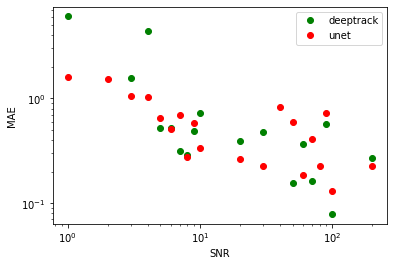

In [37]:
plt.loglog(SNRs, MAEs_deeptrack_multi, 'go',label='deeptrack')
plt.loglog(SNRs, MAEs_unet, 'ro',label='unet')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('SNR')
plt.show()